# Lending Club - Predicting loan application rejections

_We are trying to forecast the number of loans rejected per month using Arima Time Series and LTSM models_

https://www.lendingclub.com/info/download-data.action

In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import seaborn as sns


from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
%matplotlib inline

_Import the Lending Club rejection Application Datae from the Lending Club website_

In [2]:
df2017Q1 = pd.read_csv('RejectStats_2017Q1.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]
df2017Q2 = pd.read_csv('RejectStats_2017Q2.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]
df2017Q3 = pd.read_csv('RejectStats_2017Q3.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]
df2017Q4 = pd.read_csv('RejectStats_2017Q4.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]
df2018Q1 = pd.read_csv('RejectStats_2018Q1.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]
df2018Q2 = pd.read_csv('RejectStats_2018Q2.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]
df2018Q3 = pd.read_csv('RejectStats_2018Q3.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]
df2018Q4 = pd.read_csv('RejectStats_2018Q4.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]
df2019Q1 = pd.read_csv('RejectStats_2019Q1.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]

In [3]:
loans = [df2017Q1, df2017Q2, df2017Q3, df2017Q4,
         df2018Q1, df2018Q2, df2018Q3, df2018Q4, df2019Q1]
df = pd.concat(loans)
df.to_csv('RejectedLoans.csv')

_Only import the application data as the data_

In [4]:
df = pd.read_csv('RejectedLoans.csv')
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df = df.dropna()

In [6]:
df.head()

,Application Date
0,2017-01-01
1,2017-01-01
2,2017-01-01
3,2017-01-01
4,2017-01-01


In [7]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19158655 entries, 0 to 19158654
Data columns (total 1 columns):
Application Date    object
dtypes: object(1)
memory usage: 292.3+ MB


((19158655, 1), None)

_The forecast will be computed on a weekly basis_

In [8]:
# https://stackoverflow.com/questions/45281297/group-by-week-in-pandas#45281439
# http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html
df.rename(columns={'Application Date': 'Application_Date'}, inplace=True)
df['Count'] = 1
df['Application_Date'] = pd.to_datetime(
    df['Application_Date']) - pd.to_timedelta(7, unit='d')
df = df.groupby([pd.Grouper(key='Application_Date', freq='W-MON')]
                )['Count'].sum().reset_index().sort_values('Application_Date')

In [9]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 117
Data columns (total 2 columns):
Application_Date    118 non-null datetime64[ns]
Count               118 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


((118, 2), None)

In [10]:
df.head()

,Application_Date,Count
0,2016-12-26,19659
1,2017-01-02,119903
2,2017-01-09,112116
3,2017-01-16,110457
4,2017-01-23,108717


In [11]:
# I will drop the 2016 date.
df = df.loc[1:, :]

In [12]:
df.head()

,Application_Date,Count
1,2017-01-02,119903
2,2017-01-09,112116
3,2017-01-16,110457
4,2017-01-23,108717
5,2017-01-30,107435


In [13]:
df.shape

(117, 2)

_Our dataset is not down to 117 rows, which is 117 weeks of loan data._

In [14]:
df['Application_Date'] = pd.to_datetime(df['Application_Date'])

_What is the time range of the data_

In [15]:
print("Starts date {}".format(df['Application_Date'].min()))
print("Ends date {}".format(df['Application_Date'].max()))

Starts date 2017-01-02 00:00:00
Ends date 2019-03-25 00:00:00


In [16]:
dfIndex = df.set_index('Application_Date')
dfIndex.index

DatetimeIndex(['2017-01-02', '2017-01-09', '2017-01-16', '2017-01-23',
               '2017-01-30', '2017-02-06', '2017-02-13', '2017-02-20',
               '2017-02-27', '2017-03-06',
               ...
               '2019-01-21', '2019-01-28', '2019-02-04', '2019-02-11',
               '2019-02-18', '2019-02-25', '2019-03-04', '2019-03-11',
               '2019-03-18', '2019-03-25'],
              dtype='datetime64[ns]', name='Application_Date', length=117, freq=None)

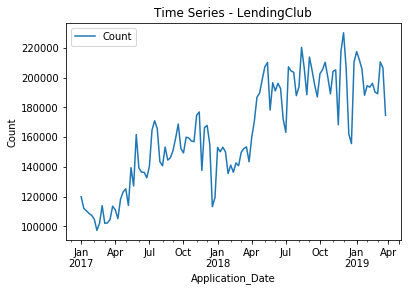

In [17]:
dfIndex.plot()
plt.title('Time Series - LendingClub')
plt.xlabel('Application_Date')
plt.ylabel('Count')
plt.show()

_The data is not stationary, therefore we have to take the difference_

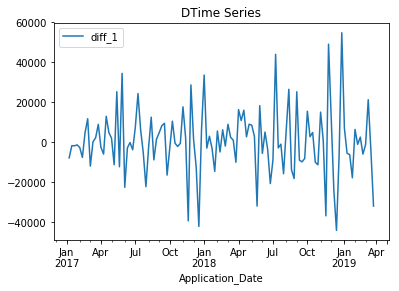

In [18]:
dfIndex['diff_1'] = dfIndex.Count - dfIndex.Count.shift()
dfIndex.plot(y='diff_1')
plt.title('DTime Series')
plt.show()

In [19]:
dfIndex.head()

,Count,diff_1
Application_Date,,
2017-01-02,119903,NaN
2017-01-09,112116,-7787.0
2017-01-16,110457,-1659.0
2017-01-23,108717,-1740.0
2017-01-30,107435,-1282.0


In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
dfIndex = dfIndex.dropna()
dfIndex = dfIndex.drop('diff_1', axis=1)
decomposition = seasonal_decompose(dfIndex, model='additive')

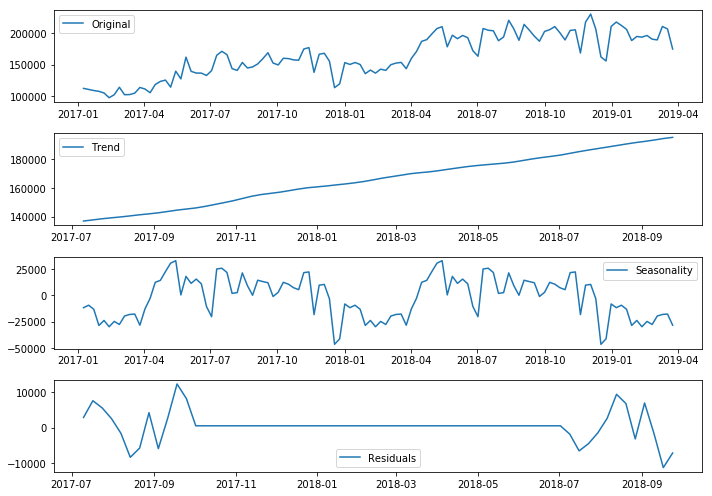

In [21]:
plt.figure(figsize=(10, 7))
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

plt.subplot(411)
# plt.title('Original')
plt.plot(dfIndex.Count, label='Original')
#plt.plot(dfIndex.diff_1, label='Diff_1')
plt.legend(loc='best')

plt.subplot(412)
# plt.title('Trend')
plt.plot(trend, label='Trend')
#plt.plot(dfIndex.diff_1, label='Diff_1')
plt.legend(loc='best')

plt.subplot(413)
# plt.title('Seasonality')
plt.plot(seasonal, label='Seasonality')
#plt.plot(dfIndex.diff_1, label='Diff_1')
plt.legend(loc='best')

plt.subplot(414)
# plt.title('Residuals')
plt.plot(residuals, label='Residuals')
#plt.plot(dfIndex.diff_1, label='Diff_1')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

_There is definetly a trend and seasonality in the data.  To handle the seasonality SARIMA will be used to forecast._

In [22]:
dfIndex.head()

,Count
Application_Date,
2017-01-09,112116
2017-01-16,110457
2017-01-23,108717
2017-01-30,107435
2017-02-06,104842


_PACF for both the initial and differenced time series._

Text(0, 0.5, 'PACF')

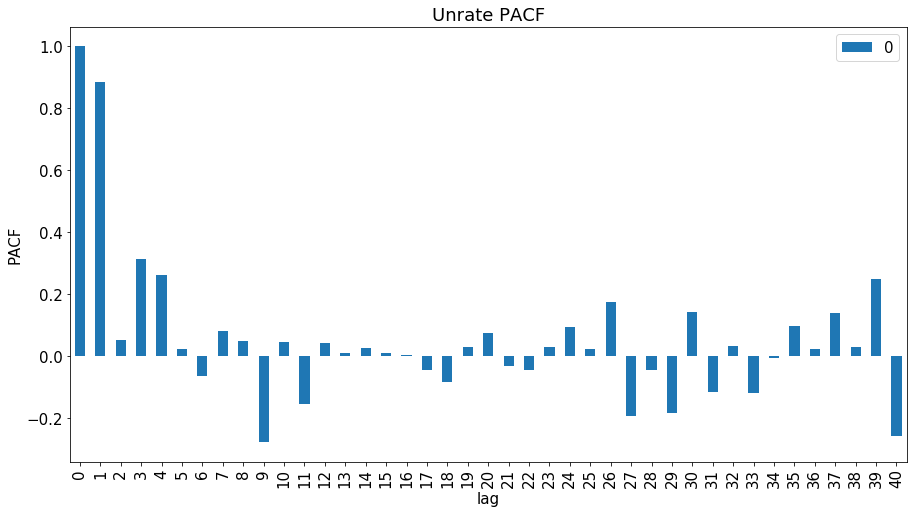

In [23]:
from statsmodels.tsa.stattools import pacf
# Plot Parameters
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.rcParams.update({'font.size': 15})
x_acf = pd.DataFrame(pacf(dfIndex.Count))
x_acf.plot(kind='bar')
plt.title("Unrate PACF")
plt.xlabel('lag')
plt.ylabel('PACF')

Text(0, 0.5, 'diff PACF')

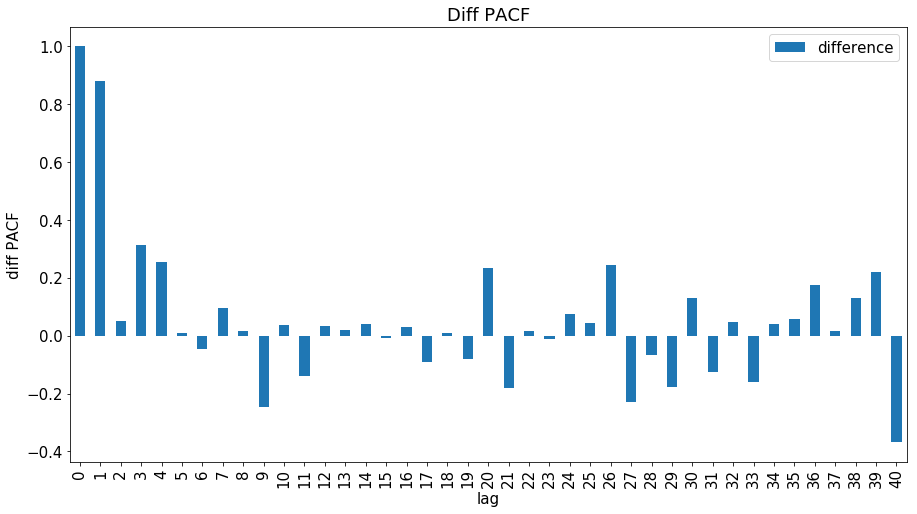

In [24]:
x_acf = pd.DataFrame(pacf(dfIndex.Count.iloc[1:]))
x_acf.plot(kind='bar')
plt.title("Diff PACF")
plt.legend(['difference'])
plt.xlabel('lag')
plt.ylabel('diff PACF')

So both the original and the difference time series has 1 strong autocorrelation. This indicates that we should look into a p of 1 for our models.  I will try modeling with using the auto arima to see what the model comes up with.


Looking at the ACF and PACF plots of the differenced series we see our first significant value at lag 4 for ACF and at the same lag 4 for the PACF which suggest to use p = 4 and q = 4. We also have a big value at lag 12 in the ACF plot which suggests our season is S = 12 and since this lag is positive it suggests P = 1 and Q = 0. Since this is a differenced series for SARIMA we set d = 1, and since the seasonal pattern is not stable over time we set D = 0. All together this gives us a SARIMA(4,1,4)(1,0,0)[12] model. Next we run SARIMA with these values to fit a model on our training data.

In [25]:
from statsmodels.tsa.stattools import adfuller

# raw data
acdf_test = adfuller(dfIndex['Count'], autolag='AIC')
df_output = pd.Series(acdf_test[0:4], index=[
                      'Test Statistic',
                      'p-value',
                      '#lags used',
                      '#nobs used'])
print('raw data\n', df_output)
for k, v in acdf_test[4].items():
    print(k, v)

raw data
 Test Statistic     -1.653998
p-value             0.454956
#lags used          3.000000
#nobs used        112.000000
dtype: float64
1% -3.4901313156261384
5% -2.8877122815688776
10% -2.5807296460459184


_From this test, we see the time series is not stationary because the p-value is > 0.05_

__Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)__
    * The ACF/PACF plots don't show a quick drop-off therefore it is not stationary.
    * This data is non-stationary as a high number of previous observations are correlated with future values.
    * Confidence intervals are the shaded area therefore any point outside is considered correlated.

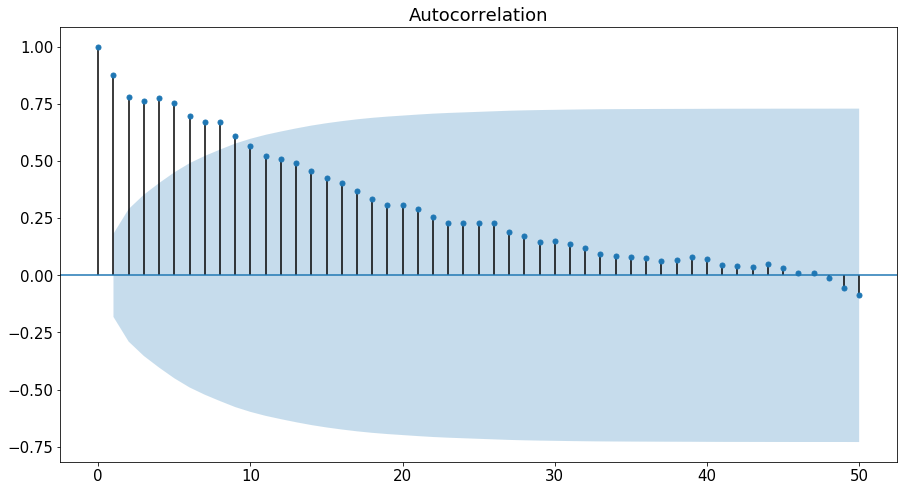

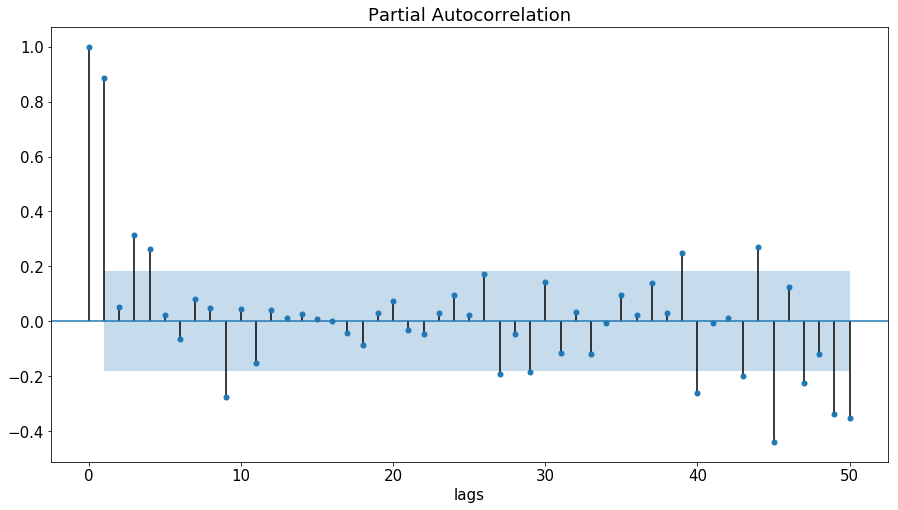

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_acf(dfIndex['Count'], lags=50)
plot_pacf(dfIndex['Count'], lags=50)
plt.xlabel('lags')
plt.show()

## Building models.

So our both time series has 1 strong autocorrelation. Let's build some ARIMA models to experiment and see how we do!

We're going to build a series of models to evaluate, each with slightly different parameters for the ARIMA. Note that the parameteres are passed in (p, d, q) order, corresponding to the AR, I, and MA portions respectively.

Recall how we interpret those attributes. The AR is the past values, I is the level of differencing, and MA is adjusting to past errors.

_Now we need to find the best model, one which has the lowesr AIC._

In [27]:
# https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(dfIndex['Count'],
                          start_p=0, start_q=0,
                          max_p=13, max_q=13, m=13,
                          start_P=0, start_Q=0,
                          seasonal=True,
                          d=1, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          random_state=42,
                          n_fits=3,
                          stepwise=True) 
stepwise_model.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 13); AIC=2337.103, BIC=2342.353, Fit time=0.026 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 13); AIC=2301.396, BIC=2311.896, Fit time=0.137 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 13); AIC=2287.446, BIC=2297.945, Fit time=0.455 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 13); AIC=2287.025, BIC=2300.150, Fit time=0.239 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 13); AIC=2294.004, BIC=2304.504, Fit time=0.265 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 13); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 13); AIC=2328.712, BIC=2336.587, Fit time=0.093 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 13); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 13); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 13); AIC=229

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  116
Model:             SARIMAX(0, 1, 2)x(1, 1, 1, 13)   Log Likelihood               -1134.857
Date:                            Mon, 08 Jul 2019   AIC                           2281.713
Time:                                    02:17:06   BIC                           2297.463
Sample:                                         0   HQIC                          2288.091
                                            - 116                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -315.9325    725.235     -0.436      0.663   -1737.367    1105.502
ma.L1         -0.3026      0.238     -1.272      0.204      -0.769       0.164
ma.L2         -0.2153      0.198     -1.086      0.278      -0.604       0.173
ar.S.L13      -0.2300      0.210     -1.096      0.273      -0.641       0.181
ma.S.L13      -0.6329      0.261     -2.428      0.015      -1.144      -0.122
sigma2      4.291e+08      0.001   7.23e+11      0.000    4.29e+08    4.29e+08
===================================================================================
Ljung-Box (Q):                       38.70   Jarque-Bera (JB):                 0.85
Prob(Q):                              0.53   Prob(JB):                         0.65
Heteroskedasticity (H):               1.30   Skew:                             0.14
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.64e+27. Standard errors may be unstable.
"""

In [28]:
dfIndex.shape

(116, 1)

_Separate out the train and test for modeling.  I will use 8 weeks of data for the test data which leaves 108 weeks for training._

In [29]:
train, test = dfIndex[:108], dfIndex[108:]
train.shape, test.shape

((108, 1), (8, 1))

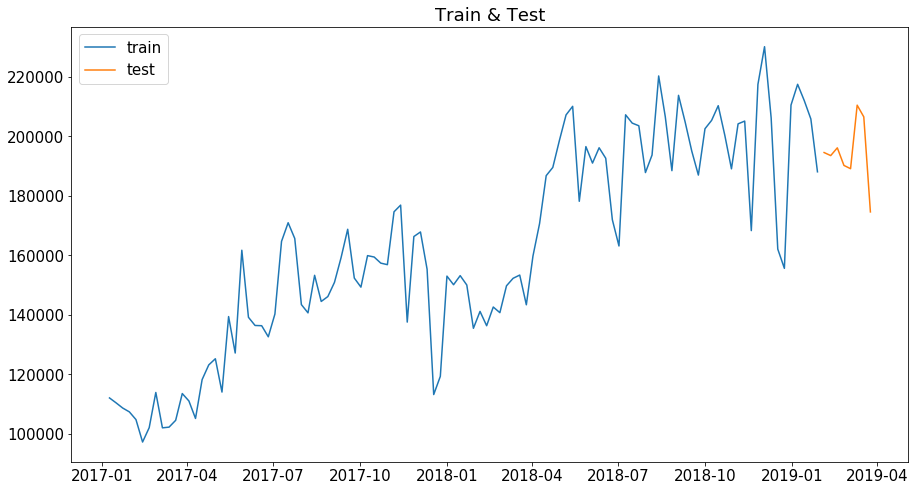

In [30]:
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.title('Train & Test')
plt.legend(loc='upper left')
plt.show()

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['Count'], order=(0, 1, 2), seasonal_order=(
    1, 1, 1, 13), enforce_invertibility=True)
results = model.fit()
results.summary()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Count   No. Observations:                  108
Model:             SARIMAX(0, 1, 2)x(1, 1, 1, 13)   Log Likelihood               -1044.654
Date:                            Mon, 08 Jul 2019   AIC                           2099.308
Time:                                    02:17:08   BIC                           2112.025
Sample:                                01-09-2017   HQIC                          2104.445
                                     - 01-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2829      0.204     -1.388      0.165      -0.682       0.117
ma.L2         -0.1902      0.179     -1.061      0.289      -0.541       0.161
ar.S.L13      -0.1997      0.212     -0.944      0.345      -0.614       0.215
ma.S.L13      -0.5822      0.255     -2.280      0.023      -1.083      -0.082
sigma2       3.93e+08   2.64e-10   1.49e+18      0.000    3.93e+08    3.93e+08
===================================================================================
Ljung-Box (Q):                       38.78   Jarque-Bera (JB):                 1.68
Prob(Q):                              0.53   Prob(JB):                         0.43
Heteroskedasticity (H):               1.56   Skew:                             0.14
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.24e+34. Standard errors may be unstable.
"""

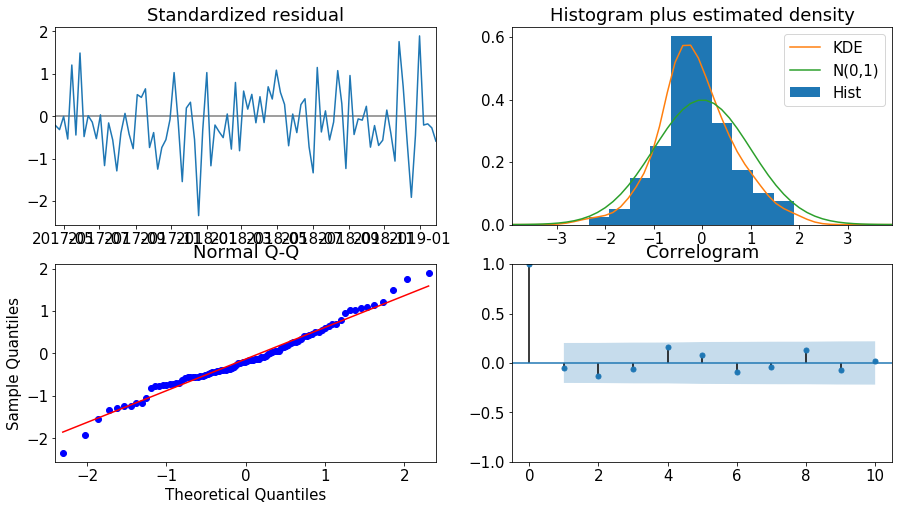

In [32]:
results.plot_diagnostics()
plt.show()

_The residuals look random and normaly distributed_

In [33]:
pred = pd.DataFrame(stepwise_model.predict(n_periods=8),
                    index=test.index)
pred.columns = ['Predicted_Num_Loans']

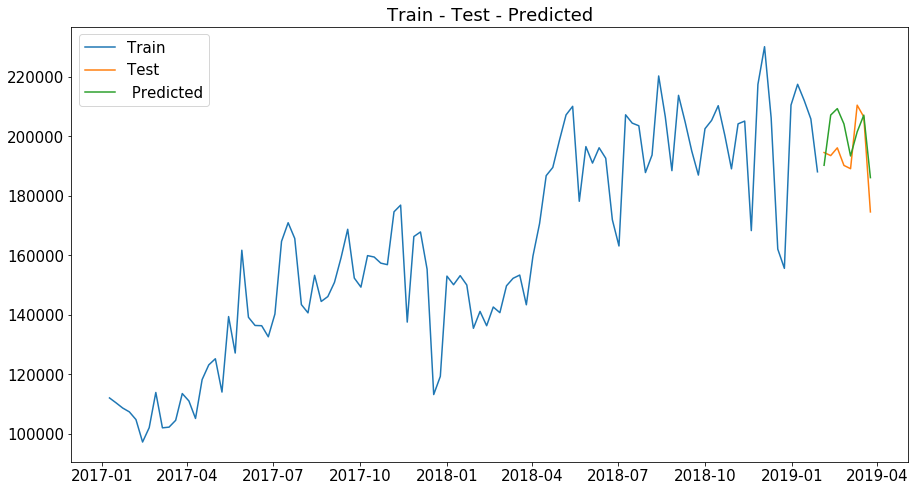

In [34]:
plt.title('Train - Test - Predicted')
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred, label=' Predicted')
plt.legend(loc='upper left')
plt.show()

In [35]:
test['Predicted'] = pred
test['Error'] = test['Count']-test['Predicted']
test

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Count,Predicted,Error
Application_Date,,,
2019-02-04,194570,190282.514309,4287.485691
2019-02-11,193545,207165.140204,-13620.140204
2019-02-18,196149,209330.691465,-13181.691465
2019-02-25,190241,204185.997558,-13944.997558
2019-03-04,189141,193419.028761,-4278.028761
2019-03-11,210487,201513.062827,8973.937173
2019-03-18,206549,207129.721024,-580.721024
2019-03-25,174618,186142.098573,-11524.098573


In [36]:
test.shape, len(test)

((8, 3), 8)

_Calculating the percent difference_

count.sum()- predicted.sum() / num of loans

In [37]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

rmse = rmse(test['Predicted'], test['Count'])
mse = mean_squared_error(test['Predicted'], test['Count'])
print('Root Mean Square Error {}'.format(rmse))
print('mean squared error {}'.format(mse))

percent_Mean_Error = (test['Count'].sum() - test['Predicted'].sum())/(test.shape[0])
print('Percent Mean Error {}'.format(abs(percent_Mean_Error)))

Root Mean Square Error 10025.50411957507
mean squared error 100510732.85161667
Percent Mean Error 5483.531840232434


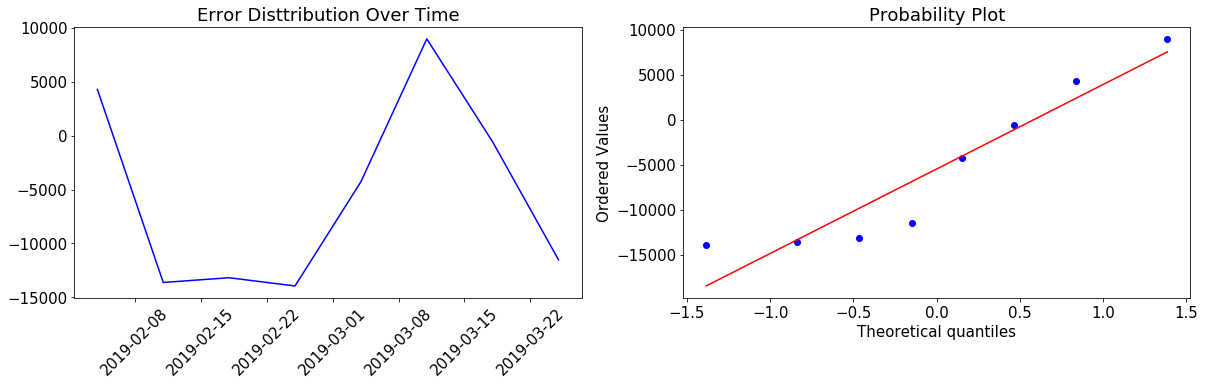

In [38]:
import pyramid as pm
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.xticks(rotation=45)
plt.plot(test.Error, color='blue')
plt.title('Error Disttribution Over Time')
plt.subplot(122)
scipy.stats.probplot(test.Error, plot=plt)
plt.show()

In [39]:
# Obtain predicted values
start = len(train)
end = len(train)+len(test)-1
predictions = results.predict(
    start=start, end=end, dynamic=False, typ='levels').rename('Predictions')

In [40]:
final = pd.DataFrame(predictions).join(test)

In [41]:
final.head()

,Predictions,Count,Predicted,Error
2019-02-04,200641.327599,194570,190282.514309,4287.485691
2019-02-11,212867.369212,193545,207165.140204,-13620.140204
2019-02-18,191871.735263,196149,209330.691465,-13181.691465
2019-02-25,202893.152409,190241,204185.997558,-13944.997558
2019-03-04,213443.527422,189141,193419.028761,-4278.028761


_What does the forecast look like?_

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(dfIndex['Count'], order=(0, 1, 2), seasonal_order=(
    0, 1, 1, 13), enforce_invertibility=False)
results = model.fit()
fcast = results.predict(len(dfIndex), len(dfIndex)+24,
                        typ='levels').rename('SARIMA Forecast')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


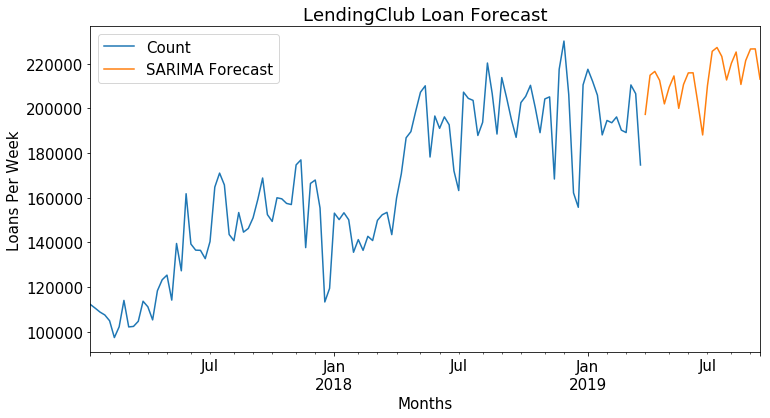

In [43]:
# Plot predictions against known values
import matplotlib.ticker as ticker
title = 'LendingClub Loan Forecast'
ylabel = 'Loans Per Week'
xlabel = 'Months'
ax = dfIndex['Count'].plot(legend=True, figsize=(12, 6), title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

--------------

# LSTM
We will use the same data for LSTM to predict 8 weeks of loans

Capable of learning long-term dependencies.  Remembering information for long periods of time. Chain of repeated moduls of neural networks.

sigmod funcion helps to determine what to keep, if it is a 1 keep other wise get rid of it.

In [44]:
import pandas as pd

df = pd.read_csv('RejectedLoans.csv')
df = df.dropna()
df.shape

(19158655, 2)

In [45]:
df = df.drop('Unnamed: 0', axis=1)

In [46]:
df.rename(columns={'Application Date': 'Application_Date'}, inplace=True)
df['Count'] = 1
df['Application_Date'] = pd.to_datetime(
    df['Application_Date']) - pd.to_timedelta(7, unit='d')
df = df.groupby([pd.Grouper(key='Application_Date', freq='W-MON')]
                )['Count'].sum().reset_index().sort_values('Application_Date')

In [47]:
#df = df.dropna()
df = df.loc[1:,:]
df.shape

(117, 2)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 1 to 117
Data columns (total 2 columns):
Application_Date    117 non-null datetime64[ns]
Count               117 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.7 KB


In [49]:
df.head()

,Application_Date,Count
1,2017-01-02,119903
2,2017-01-09,112116
3,2017-01-16,110457
4,2017-01-23,108717
5,2017-01-30,107435


In [50]:
dataset = df.values


_We will try to predict 8 weeks of loans_

In [51]:
dataset_train, dataset_test = df[0:109], df[109:117]

In [52]:
training_set = dataset_train.iloc[:, 1:2].values
testing_set = dataset_test.iloc[:, 1:2].values

In [53]:
dataset_train.info(), dataset_test.shape, training_set.shape, testing_set.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 1 to 109
Data columns (total 2 columns):
Application_Date    109 non-null datetime64[ns]
Count               109 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.6 KB


(None, (8, 2), (109, 1), (8, 1))

In [54]:
dataset_train.isna().sum()
dataset_test.isna().sum()

Application_Date    0
Count               0
dtype: int64

In [55]:
dataset_test.head()

,Application_Date,Count
110,2019-02-04,194570
111,2019-02-11,193545
112,2019-02-18,196149
113,2019-02-25,190241
114,2019-03-04,189141


In [56]:
training_set.shape

(109, 1)

In [57]:
dataset_train.shape

(109, 2)

In [58]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(testing_set)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


I am predicting the next 2 months (8 weeks)

I am predicting 109-8 because the first 8 I can't predict becasue there isn't anyting behind it to predict. therefore (101,8,1)

In [59]:
#create matrix
X_train = []
y_train = []
for i in range(8, 109):#8 time steps to figure out the next step
    X_train.append(training_set_scaled[i-8:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [60]:
X_test = []
y_test = []
for i in range(0,8):
    X_test.append(testing_set_scaled[i-0:i, 0])
    y_test.append(testing_set_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [61]:
#matrix has 101 rows and 8 columns
#and trying to figure out the next step
#after the 8 time steps

#I am using the previous 8 time step(week) to predict the 9th time step(week)
X_train.shape,X_test.shape

((101, 8, 1), (8, 0, 1))

In [62]:
#!pip install keras
#!pip install tensorflow
#!tensorboard --logdir=logs


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.callbacks import TensorBoard
from keras.optimizers import SGD

'''import tensorflow as tf
import time

g = tf.Graph() with g.as_default():


summaries = tf.summary.merge_all() log_writer =
tf.summary.FileWriter(log_dir, graph = g)'''

#NAME= 'LendingClub-LSTM-{}'.format(int(time.time()))
tensorboard = TensorBoard()



Using TensorFlow backend.


_To prevent overfitting(wrong connections) I will randomly disable some neurons. 3 layer with 1 output. Adam learning rate will be used and 10 epoch(back and forths that are done)__


3 layers and outputing 1
adam learning rate of NN

epocs number of back and forths
batch is 60

In [63]:
lstm_model = Sequential()

lstm_model.add(LSTM(units = 90, 
                   return_sequences = True, 
                   input_shape = (X_train.shape[1], 1)))
lstm_model.add(Dropout(0.7))

lstm_model.add(LSTM(units = 90,return_sequences = True))
lstm_model.add(Dropout(0.7))

lstm_model.add(LSTM(units = 90,return_sequences = True))
lstm_model.add(Dropout(0.7))

lstm_model.add(LSTM(units = 90))
lstm_model.add(Dropout(0.7))

lstm_model.add(Dense(units = 1)) 


lstm_model.compile(optimizer = 'adam', 
                  loss = 'mean_squared_error')
                 
history=lstm_model.fit(X_train, 
              y_train, 
              epochs = 900, 
              batch_size = 1)


W0708 02:17:28.977895 4586948032 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 02:17:29.007314 4586948032 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 02:17:29.019309 4586948032 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0708 02:17:29.308710 4586948032 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:13

Epoch 1/900
101/101 [==============================] - 5s 50ms/step - loss: 0.0733
Epoch 2/900
101/101 [==============================] - 3s 27ms/step - loss: 0.0444
Epoch 3/900
101/101 [==============================] - 4s 37ms/step - loss: 0.0436
Epoch 4/900
101/101 [==============================] - 4s 36ms/step - loss: 0.0506
Epoch 5/900
101/101 [==============================] - 4s 36ms/step - loss: 0.0449
Epoch 6/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0449
Epoch 7/900
101/101 [==============================] - 4s 35ms/step - loss: 0.0538
Epoch 8/900
101/101 [==============================] - 3s 32ms/step - loss: 0.0340
Epoch 9/900
101/101 [==============================] - 3s 30ms/step - loss: 0.0367
Epoch 10/900
101/101 [==============================] - 3s 27ms/step - loss: 0.0381
Epoch 11/900
101/101 [==============================] - 3s 27ms/step - loss: 0.0375
Epoch 12/900
101/101 [==============================] - 3s 27ms/step - loss: 0.0480
E

101/101 [==============================] - 3s 28ms/step - loss: 0.0226
Epoch 99/900
101/101 [==============================] - 3s 27ms/step - loss: 0.0210
Epoch 100/900
101/101 [==============================] - 3s 28ms/step - loss: 0.0208
Epoch 101/900
101/101 [==============================] - 3s 28ms/step - loss: 0.0217
Epoch 102/900
101/101 [==============================] - 3s 29ms/step - loss: 0.0225
Epoch 103/900
101/101 [==============================] - 3s 29ms/step - loss: 0.0244
Epoch 104/900
101/101 [==============================] - 3s 29ms/step - loss: 0.0229
Epoch 105/900
101/101 [==============================] - 3s 30ms/step - loss: 0.0232
Epoch 106/900
101/101 [==============================] - 3s 28ms/step - loss: 0.0267
Epoch 107/900
101/101 [==============================] - 3s 28ms/step - loss: 0.0224
Epoch 108/900
101/101 [==============================] - 3s 29ms/step - loss: 0.0237
Epoch 109/900
101/101 [==============================] - 3s 33ms/step - loss: 0.

101/101 [==============================] - 4s 38ms/step - loss: 0.0184
Epoch 195/900
101/101 [==============================] - 4s 39ms/step - loss: 0.0183
Epoch 196/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0177
Epoch 197/900
101/101 [==============================] - 4s 40ms/step - loss: 0.0213
Epoch 198/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0190
Epoch 199/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0180
Epoch 200/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0224
Epoch 201/900
101/101 [==============================] - 4s 39ms/step - loss: 0.0209
Epoch 202/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0154
Epoch 203/900
101/101 [==============================] - 4s 39ms/step - loss: 0.0187
Epoch 204/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0159
Epoch 205/900
101/101 [==============================] - 4s 38ms/step - loss: 0

101/101 [==============================] - 4s 44ms/step - loss: 0.0127
Epoch 291/900
101/101 [==============================] - 5s 45ms/step - loss: 0.0124
Epoch 292/900
101/101 [==============================] - 4s 44ms/step - loss: 0.0141
Epoch 293/900
101/101 [==============================] - 4s 44ms/step - loss: 0.0171
Epoch 294/900
101/101 [==============================] - 5s 45ms/step - loss: 0.0148
Epoch 295/900
101/101 [==============================] - 4s 44ms/step - loss: 0.0124
Epoch 296/900
101/101 [==============================] - 4s 44ms/step - loss: 0.0138
Epoch 297/900
101/101 [==============================] - 4s 44ms/step - loss: 0.0180
Epoch 298/900
101/101 [==============================] - 5s 45ms/step - loss: 0.0143
Epoch 299/900
101/101 [==============================] - 4s 44ms/step - loss: 0.0157
Epoch 300/900
101/101 [==============================] - 5s 45ms/step - loss: 0.0138
Epoch 301/900
101/101 [==============================] - 4s 44ms/step - loss: 0

101/101 [==============================] - 3s 31ms/step - loss: 0.0142
Epoch 387/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0114
Epoch 388/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0121
Epoch 389/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0104
Epoch 390/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0118
Epoch 391/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0134
Epoch 392/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0107
Epoch 393/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0120
Epoch 394/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0125
Epoch 395/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0123
Epoch 396/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0161
Epoch 397/900
101/101 [==============================] - 3s 31ms/step - loss: 0

101/101 [==============================] - 3s 31ms/step - loss: 0.0121
Epoch 483/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0099
Epoch 484/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0104
Epoch 485/900
101/101 [==============================] - 3s 32ms/step - loss: 0.0132
Epoch 486/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0094
Epoch 487/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0095
Epoch 488/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0087
Epoch 489/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0106
Epoch 490/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0120
Epoch 491/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0125
Epoch 492/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0121
Epoch 493/900
101/101 [==============================] - 3s 31ms/step - loss: 0

101/101 [==============================] - 3s 31ms/step - loss: 0.0112
Epoch 579/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0087
Epoch 580/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0098
Epoch 581/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0088
Epoch 582/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0104
Epoch 583/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0114
Epoch 584/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0098
Epoch 585/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0095
Epoch 586/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0108
Epoch 587/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0083
Epoch 588/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0097
Epoch 589/900
101/101 [==============================] - 3s 31ms/step - loss: 0

101/101 [==============================] - 3s 31ms/step - loss: 0.0085
Epoch 675/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0071
Epoch 676/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0085
Epoch 677/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0094
Epoch 678/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0090
Epoch 679/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0081
Epoch 680/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0092
Epoch 681/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0102
Epoch 682/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0080
Epoch 683/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0084
Epoch 684/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0101
Epoch 685/900
101/101 [==============================] - 3s 31ms/step - loss: 0

101/101 [==============================] - 3s 31ms/step - loss: 0.0076
Epoch 771/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0078
Epoch 772/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0088
Epoch 773/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0080
Epoch 774/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0084
Epoch 775/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0082
Epoch 776/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0081
Epoch 777/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0068
Epoch 778/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0066
Epoch 779/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0082
Epoch 780/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0087
Epoch 781/900
101/101 [==============================] - 3s 32ms/step - loss: 0

101/101 [==============================] - 3s 33ms/step - loss: 0.0061
Epoch 867/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0085
Epoch 868/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0075
Epoch 869/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0057
Epoch 870/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0093
Epoch 871/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0054
Epoch 872/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0086
Epoch 873/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0070
Epoch 874/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0063
Epoch 875/900
101/101 [==============================] - 3s 32ms/step - loss: 0.0078
Epoch 876/900
101/101 [==============================] - 3s 31ms/step - loss: 0.0070
Epoch 877/900
101/101 [==============================] - 3s 31ms/step - loss: 0

In [64]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8, 90)             33120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 90)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 90)             65160     
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 90)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 8, 90)             65160     
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 90)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 90)                65160     
__________

In [65]:
true_loan_count = dataset_test.iloc[:, 1:2].values

In [66]:
true_loan_count

array([[194570],
       [193545],
       [196149],
       [190241],
       [189141],
       [210487],
       [206549],
       [174618]])

In [67]:
dataset_train.shape, dataset_test.shape

((109, 2), (8, 2))

In [68]:
dataset_total = pd.concat((dataset_train['Count'],
                           dataset_test['Count']),
                          axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 8:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
#inputs

In [69]:
X_test = []
for i in range(8, 16):
    X_test.append(inputs[i-8:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_loans = lstm_model.predict(X_test)
predicted_loans = sc.inverse_transform(predicted_loans)

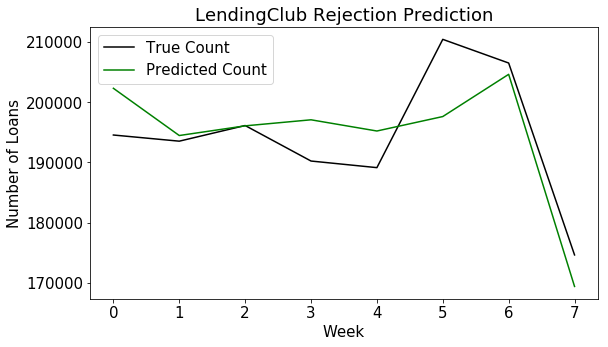

RMSE Train Score: 5762.00
MSE Train Score: 33200682.4385 

RMSE Test Score: 6534.2960 
MSE Test Score: 42697024.6312 


In [70]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(true_loan_count, color='black', label='True Count')
plt.plot(predicted_loans, color='green', label='Predicted Count')
plt.title('LendingClub Rejection Prediction')
plt.xlabel('Week')
plt.ylabel('Number of Loans')
plt.legend()
plt.show()


# make predictions
import math
trainPredict = lstm_model.predict(X_train)
testPredict = lstm_model.predict(X_test)
# invert predictions
trainPredict = sc.inverse_transform(trainPredict)
trainY = sc.inverse_transform([y_train])

testPredict = sc.inverse_transform(testPredict)
testY = sc.inverse_transform([y_test])
# calculate root mean squared error
trainScore1 = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print(f'RMSE Train Score: {trainScore1:.2f}' )
trainScore2 = mean_squared_error(trainY[0], trainPredict[:,0])
print('MSE Train Score: %.4f ' % (trainScore2))

testScore3 = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('\nRMSE Test Score: %.4f ' % (testScore3))
testScore4 = mean_squared_error(testY[0], testPredict[:,0])
print('MSE Test Score: %.4f ' % (testScore4))

_From the plot the model didn't do that well, it is overfitting.  It is predicting more rejections. The root mean square of the  actual and the predicted are not close at all._

W0708 03:08:03.673815 4586948032 legend.py:1289] No handles with labels found to put in legend.


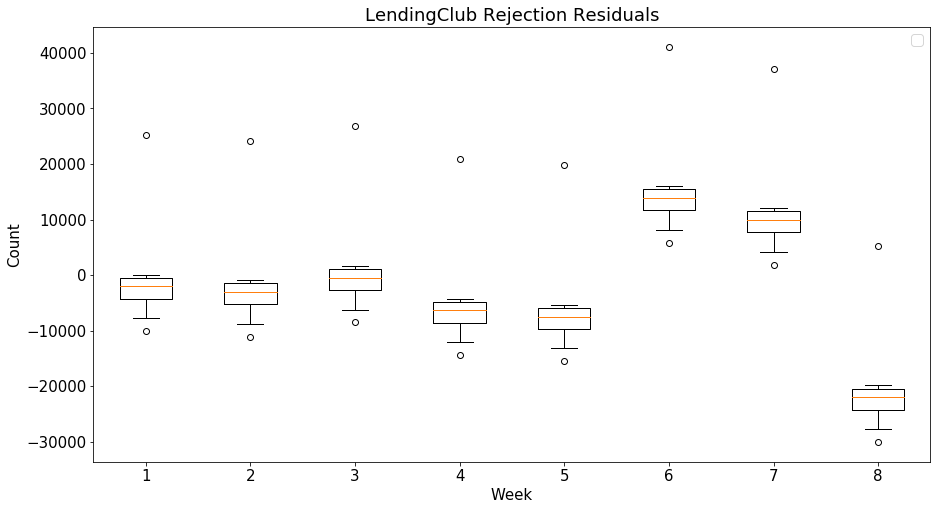

In [71]:
plt.title('LendingClub Rejection Residuals')
plt.xlabel('Week')
plt.ylabel('Count')
plt.legend()
residual = testY - testPredict
plt.boxplot(residual)
plt.show()

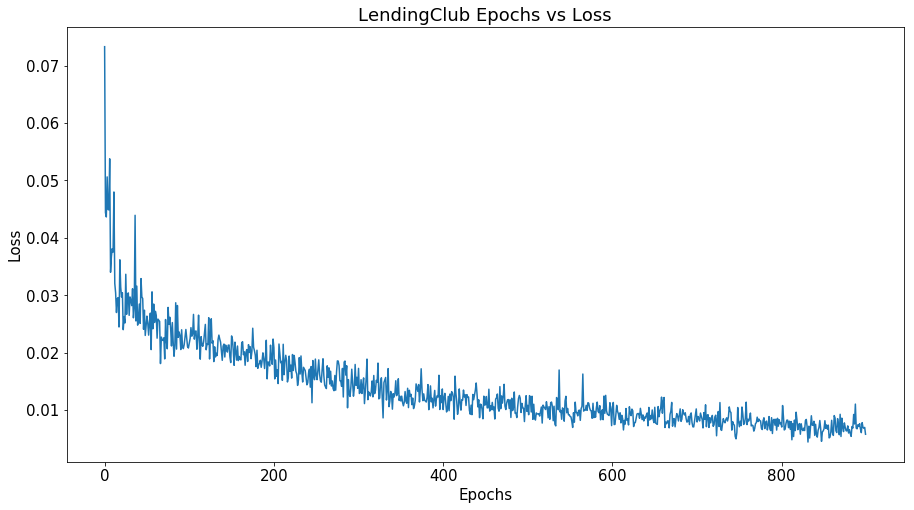

In [72]:
plt.title('LendingClub Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])